# Recommendations for Ford Go-Bike

##### Author: Alexandra West

#### Problem: 
How do we increase ridership for the Bay Area Bike Share?

#### Organization: 
Ford Go-Bike

#### Dataset: 
Bay Area Bikeshare status, Bay Area Bikeshare trips 

#### Tools: 
Google Cloud Platform (GCP) through BigQuery

This project answers the following questions:

- **What are the 5 most popular trips that you would call "commuter trips"?**
  
- **What are your recommendations for offers through the mobile app?**
  
Currently, the company has three options: 

1) a flat price for a single one-way trip,

2) a day pass that allows unlimited 30-minute rides for 24 hours,

3) and an annual membership. 

In the course of this report, I will evaluate the data, identify commuter trips, and recommend options for new offers through the mobile app in order to increase ridership.


In [53]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Data Exploration

These initial questions are important to set the stage for more focused analysis to follow. I will not include the queries for these questions, as they were included in previous assignments.

- What's the size of this dataset? (i.e., how many trips)

There are **983,648** trips in this dataset.

- What is the earliest start time and latest end time for a trip?

Earliest start time (including date) is **2013-08-29 09:08:00**, latest end time (including date) is **2016-08-31 23:48:00**.

- How many bikes are there?

There are **700** bikes.

- Longest and shortest trips?

Shortest, **60 seconds**, longest, **172,704,000 seconds or about 200 days**. This may be a glitch in the system and could be removed.

- Average length of trip?

1018 seconds or almost **17 minutes**.

- Are more trips round trips or one-way trips? 

One way trips: **951,601**, Round trips: **32,047**. Round trips make up such a small percentage of the total - barely over 3% of the total number of trips. It is clear that people view the bikes as a means of getting from place to place, and even if they do return to the same location, they will get another bike so as to not go over the 30 minute limit.

These questions give us a basic picture of the dataset. There are clearly some outliers, but even with the longest trip included, the average length is still only 17 minutes. This is a nice segue into answering the first question - what are the five most popular trips that you would call commuter trips?

## Commuter Trips

Question: **What are the 5 most popular trips that you would call "commuter trips"?**

Before answering this specific question, we must first define a few things. What is a _commuter_ trip? We can define it simply as a one-way trip, usually beginning a person's journey either to or from work, filling in one portion of the commute. For the purposes of this exercise, the commuting hours are defined to be from 7-10 am, and from 3-6 pm (for typical 8 hour workdays). These would not be round trips. Also, they are likely to be shorter - probably under 30 minutes. Also, they will probably originate at more residential stations in the morning, and in business districts in the afternoon. 

With those definitions out of the way, we can begin to narrow down the data to define the 5 most common commuter trips. These trips will be defined as start station, end station, with a time range.

To do this, I will segment the data into morning commutes and afternoon commutes (trips between certain hours of the day) and analyze those specific segments.

Earlier analysis of the commute times made it obvious that the vast majority of trips are under an hour, so I will define commuter trips to be under 45 minutes, or around 2700 seconds. I will limit the csv to 500000 rows, hoping to catch enough of a sample size to be significant for both morning and afternoon.

In [90]:
# first creating a dataset with all morning commutes,
# one way trips between 7 and 10 am
# 45 min or less, overriding the csv max_rows limit

! bq query --use_legacy_sql=FALSE --format=csv --max_rows=500000 'SELECT * FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE EXTRACT (hour FROM start_date AT TIME ZONE "UTC") BETWEEN 7 AND 10 AND start_station_name <> end_station_name AND duration_sec < 2700' > morning_commutes_timed.csv

Waiting on bqjob_r4fa4bbab3692eed8_00000168cb5eea8c_1 ... (3s) Current status: DONE   

In [91]:
# take a look at the morning commute rides
# defined as rides between 7 and 10 am and less 
# than or equal to 45 min

morning=pd.read_csv('morning_commutes_timed.csv')
morning.head()

,trip_id,duration_sec,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_number,zip_code,subscriber_type
0,951818,206,2015-09-30 09:59:00,Redwood City Caltrain Station,22,2015-09-30 10:02:00,Mezes,83,175,94707,Subscriber
1,1068760,241,2016-01-23 09:43:00,Redwood City Caltrain Station,22,2016-01-23 09:47:00,Mezes,83,155,94070,Subscriber
2,948306,239,2015-09-28 09:20:00,Redwood City Caltrain Station,22,2015-09-28 09:24:00,Mezes,83,93,94707,Subscriber
3,949971,201,2015-09-29 09:22:00,Redwood City Caltrain Station,22,2015-09-29 09:26:00,Mezes,83,93,94707,Subscriber
4,942343,183,2015-09-23 09:29:00,Redwood City Caltrain Station,22,2015-09-23 09:32:00,Mezes,83,694,94707,Subscriber


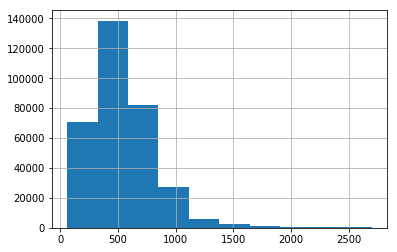

In [92]:
# histogram of one way morning rides under 45 min

morning.duration_sec.hist()

It is obvious that most trips that begin between 7 and 10 am are less than 2500 seconds, or 41 minutes. Perhaps instead of limiting commuter rides to 30 minutes, we can stretch the length to 45 minutes. 

Looking at the data this close, it seems that there are a lot of trips that actually last less than 10 minutes. However, for commuter trips, we will keep the timing bracket at 45 minutes. We can apply the same logic to the afternoon rides.

In [93]:
# next, create a dataset that limits afternoon commute to 
# one way trips that are 45 minutes or less (or 2700 seconds)
# between 3 and 6 pm, overriding the max_rows limit

! bq query --use_legacy_sql=FALSE --format=csv --max_rows=500000 'SELECT * FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE EXTRACT (hour FROM start_date) BETWEEN 15 AND 19 AND start_station_name <> end_station_name AND duration_sec <= 2700'> afternoon_commutes_timed.csv

Waiting on bqjob_rf024f83f3cc84e0_00000168cb61c672_1 ... (0s) Current status: DONE   

In [98]:
# take a look at the afternoon commute rides

afternoon=pd.read_csv('afternoon_commutes_timed.csv')
afternoon.head()

,trip_id,duration_sec,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_number,zip_code,subscriber_type
0,957659,587,2015-10-05 16:41:00,Sequoia Hospital,21,2015-10-05 16:51:00,Mezes,83,650,94063,Subscriber
1,1029835,301,2015-12-04 17:32:00,Redwood City Caltrain Station,22,2015-12-04 17:37:00,Mezes,83,155,94063,Subscriber
2,987584,325,2015-10-27 17:32:00,Redwood City Caltrain Station,22,2015-10-27 17:38:00,Mezes,83,52,94063,Subscriber
3,1009081,385,2015-11-13 17:09:00,Redwood City Caltrain Station,22,2015-11-13 17:15:00,Mezes,83,199,94063,Subscriber
4,1213934,285,2016-05-24 18:07:00,Redwood City Caltrain Station,22,2016-05-24 18:12:00,Mezes,83,91,94063,Subscriber


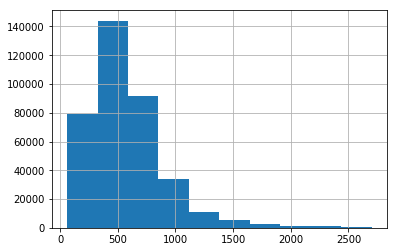

In [99]:
# histogram of one way afternoon rides under 45 minutes

afternoon.duration_sec.hist()

There is even similar variation in the afternoon rides - many of which are much less than 500 seconds (about 8 minutes). 

Now, in order to find out the answer to the question **What are the 5 most popular trips that you would call "commuter trips"?**, I will create a new column on both the morning and afternoon csvs that combines the start station name with the end station name. Then, I will count the combinations and display the top results for both morning and afternoon.

In [100]:
# create new column in the morning_timed dataframe 
# combining start and end stations

morning["start_end"] = morning["start_station_name"] + "-" + morning["end_station_name"]
morning.head()

,trip_id,duration_sec,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_number,zip_code,subscriber_type,start_end
0,951818,206,2015-09-30 09:59:00,Redwood City Caltrain Station,22,2015-09-30 10:02:00,Mezes,83,175,94707,Subscriber,Redwood City Caltrain Station-Mezes
1,1068760,241,2016-01-23 09:43:00,Redwood City Caltrain Station,22,2016-01-23 09:47:00,Mezes,83,155,94070,Subscriber,Redwood City Caltrain Station-Mezes
2,948306,239,2015-09-28 09:20:00,Redwood City Caltrain Station,22,2015-09-28 09:24:00,Mezes,83,93,94707,Subscriber,Redwood City Caltrain Station-Mezes
3,949971,201,2015-09-29 09:22:00,Redwood City Caltrain Station,22,2015-09-29 09:26:00,Mezes,83,93,94707,Subscriber,Redwood City Caltrain Station-Mezes
4,942343,183,2015-09-23 09:29:00,Redwood City Caltrain Station,22,2015-09-23 09:32:00,Mezes,83,694,94707,Subscriber,Redwood City Caltrain Station-Mezes


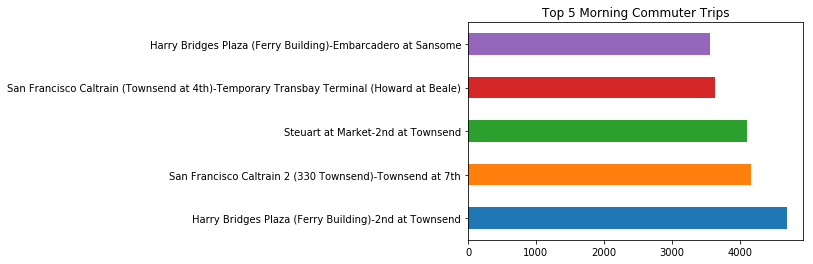

In [104]:
# count the frequency of values in the combined column
# to find the most common trips in the morning

common_mtrips=morning['start_end'].value_counts()
common_mtrips.head().plot.barh(title="Top 5 Morning Commuter Trips")

In [105]:
# create new column in the afternoon_timed dataframe 
# combining start and end stations

afternoon_timed["start_end"] = afternoon_timed["start_station_name"] + "-" + afternoon_timed["end_station_name"]
afternoon_timed.head()

,trip_id,duration_sec,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_number,zip_code,subscriber_type,start_end
0,957659,587,2015-10-05 16:41:00,Sequoia Hospital,21,2015-10-05 16:51:00,Mezes,83,650,94063,Subscriber,Sequoia Hospital-Mezes
1,1029835,301,2015-12-04 17:32:00,Redwood City Caltrain Station,22,2015-12-04 17:37:00,Mezes,83,155,94063,Subscriber,Redwood City Caltrain Station-Mezes
2,987584,325,2015-10-27 17:32:00,Redwood City Caltrain Station,22,2015-10-27 17:38:00,Mezes,83,52,94063,Subscriber,Redwood City Caltrain Station-Mezes
3,1009081,385,2015-11-13 17:09:00,Redwood City Caltrain Station,22,2015-11-13 17:15:00,Mezes,83,199,94063,Subscriber,Redwood City Caltrain Station-Mezes
4,1213934,285,2016-05-24 18:07:00,Redwood City Caltrain Station,22,2016-05-24 18:12:00,Mezes,83,91,94063,Subscriber,Redwood City Caltrain Station-Mezes


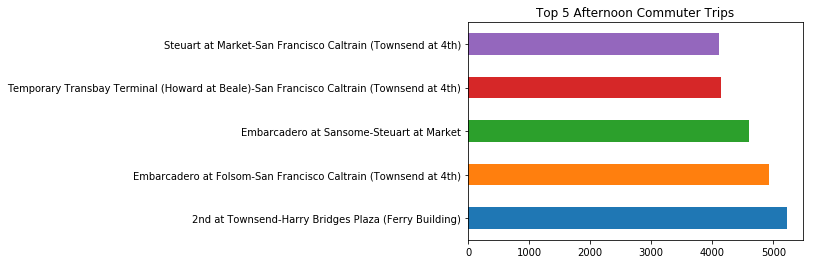

In [108]:
# count the frequency of values in the combined column
# to find the most common trips in the morning

common_atrips=afternoon_timed['start_end'].value_counts()
common_atrips.head().plot.barh(title="Top 5 Afternoon Commuter Trips")

##### The most popular morning and afternoon trip is Harry Bridges Plaza (Ferry Building) - 2nd at Townsend (and back in the afternoon).

The other trips don't map exactly one to one, so people must be riding one way and going elsewhere. This is a strong argument for the bikes being commuter modes of transportation for downtown San Francisco especially, where parking is scarce and expensive, and Bart stations are relatively far apart.



## Exploring existing users and demand

In order to increase ridership, Ford Go-Bike must examine the behavior of its existing users: subscribers as well as one-off customers. 

Questions I will be asking here include: 

- Who are the existing riders? Subscribers or casual customers?

- Who rides the longest (potentially translating to more revenue), subscribers or casual customers?

- What are the most popular trips regardless of time of day?

- Which stations have the most bikes available?


In [49]:
# create a new csv of the number of subscribers vs. 
# casual riders - csv only has two rows with label and count

! bq query --use_legacy_sql=false --format=csv 'SELECT subscriber_type, COUNT(*) AS count FROM `bigquery-public-data.san_francisco.bikeshare_trips` GROUP BY subscriber_type' > subscribers.csv

Waiting on bqjob_r705cb48dc9860b65_00000168cb04495a_1 ... (0s) Current status: DONE   

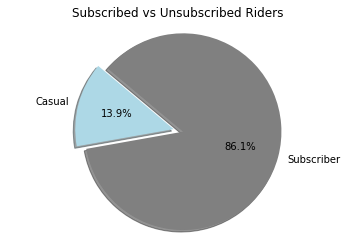

In [57]:
# create dataframe from csv
subscribers=pd.read_csv('subscribers.csv')

# create pie chart of subscribers and casual riders
labels = ['Casual', 'Subscriber']
sizes = subscribers['count']
colors = ['lightblue', 'gray']
explode = (0.1, 0)  # explode 1st slice

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140, )
plt.title('Subscribed vs Unsubscribed Riders')
plt.axis('equal')
plt.show()

The vast majority of current users are subscribers. What more do they want out of the program? How long do they typically ride the bikes? 

In [62]:
# create a csv of the average duration of subscriber type
# divide duration by 60 to translate to minutes

! bq query --use_legacy_sql=false --format=csv 'SELECT subscriber_type, AVG(duration_sec)/60 AS average FROM `bigquery-public-data.san_francisco.bikeshare_trips` GROUP BY subscriber_type' > subduration.csv


Waiting on bqjob_r56a8376ce6e56968_00000168cb188c95_1 ... (0s) Current status: DONE   

In [61]:
avgduration=pd.read_csv('subduration.csv')
avgduration

,subscriber_type,average
0,Customer,61.979753
1,Subscriber,9.712737


Casual customers tend to ride the bikes much longer on average than subscribers. They may get stung by the 30 minute limit on the day pass, and therefore may not be return customers as a result. Perhaps there is a solution in creating a specific offer for casual customers or tourists who will be riding the bikes for longer.

Also, there may be specific routes that are more popular than the commuter routes, which should be given increased capacity at different times of day.

In [63]:
# most popular routes - regardless of time of day/ commuter status

! bq query --use_legacy_sql=false --format=csv 'SELECT start_station_name, end_station_name, COUNT(*) AS Count FROM `bigquery-public-data.san_francisco.bikeshare_trips` GROUP BY start_station_name, end_station_name ORDER BY Count DESC LIMIT 10' > populartrips.csv


Waiting on bqjob_r391d9223ee3d4863_00000168cb1e9993_1 ... (0s) Current status: DONE   

In [64]:
populartrips=pd.read_csv('populartrips.csv')
populartrips

,start_station_name,end_station_name,Count
0,Harry Bridges Plaza (Ferry Building),Embarcadero at Sansome,9150
1,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,8508
2,2nd at Townsend,Harry Bridges Plaza (Ferry Building),7620
3,Harry Bridges Plaza (Ferry Building),2nd at Townsend,6888
4,Embarcadero at Sansome,Steuart at Market,6874
5,Townsend at 7th,San Francisco Caltrain 2 (330 Townsend),6836
6,Embarcadero at Folsom,San Francisco Caltrain (Townsend at 4th),6351
7,San Francisco Caltrain (Townsend at 4th),Harry Bridges Plaza (Ferry Building),6215
8,Steuart at Market,2nd at Townsend,6039
9,Steuart at Market,San Francisco Caltrain (Townsend at 4th),5959


It is clear that all the stations in downtown San Francisco are the most popular for both commuters and casual customers. These stations should be optimized for both uses, and given extra capacity throughout the day.

In [114]:
# which stations have the most bikes available, regardless of time

! bq query --use_legacy_sql=false --format=csv 'SELECT COUNT(bikes_available), station_id, COUNT(*) FROM `bigquery-public-data.san_francisco.bikeshare_status` GROUP BY station_id ORDER BY COUNT(bikes_available) DESC' > stationsmostbikes.csv

Waiting on bqjob_rdf6926e4afcfd8d_00000168cb75d06b_1 ... (1s) Current status: DONE   

In [115]:
mostbikes=pd.read_csv('stationsmostbikes.csv')
mostbikes.head()

,f0_,station_id,f1_
0,1559598,5,1559598
1,1559598,6,1559598
2,1559598,7,1559598
3,1559597,36,1559597
4,1559597,57,1559597


These five stations have less demand than the others, they could potentially diminish capacity and give more to the other stations - or Ford Go-Bike could offer particular deals to visit these stations.

## Recommendations for the mobile app

1. Offer more flexible subscriptions - a year is too long for an introduction: offer weekly, monthly, and yearly rates (yearly being the best value)

2. To entice casual riders, change the nature of the daily pass. Unlimited 30 minute rides in 24 hours is an arbitrary cutoff. A flat fee for as many rides as you can take in one day would work well. The rider can stay on the same bike all day, touring the city, or stop at multiple stations throughout the day.

3. Increase capacity at the most popular stations

4. Add a 'number of bike' status for each station to the mobile app. Consumers are more willing to subscribe if they have security in knowing where and when bikes are available. 

5. Perhaps give a customer the options of 'reserving' a bike for up to 15 minutes (no more). This would allow someone to see a bike, know they are within a 15 minute walk, and be secure in their ability to claim it once they get there. Also, 15 minutes is a short enough time period that bikes would not sit idle too long.